# Predictive modelling

## introduction

I will firstly prepare data. It includes 
* defining a reference time point
* discretise continuous variables

Then I will define what is a bad renter, and good render otherwise.


Then I will construct a group of features that may or may not be good predictors. 
(I will consider whether I need to select features)


Afterwards, I will try different modelling approaches and modelling examples (basesd on varied reference time points). And I will evaluate their predictive performance. 


(Lastly, I will try to create a scorecard.)

## 1. prepare data

### 1.1 define a reference time point

In [1]:
import warnings
warnings.filterwarnings('ignore')

In this section, I shall firstly define a reference time point (henceforth rtp), then I will define bad renters.

In [3]:
import os
import pandas as pd
import numpy as np
# in windows
os.chdir('data')
# os.chdir('../data')
data = pd.read_csv('final_data.csv', parse_dates=['contract_start', 'contract_end', 'Payment_date', 'due_date'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260412 entries, 0 to 260411
Data columns (total 15 columns):
contract_id           260412 non-null int64
postcode              260412 non-null object
rent                  260412 non-null float64
contract_start        260412 non-null datetime64[ns]
contract_end          260412 non-null datetime64[ns]
id                    260412 non-null object
contract_length       260412 non-null object
Payment_date          260412 non-null datetime64[ns]
Amount                259896 non-null float64
payment_method        260412 non-null object
transaction_length    260412 non-null int64
payment_ratio         260412 non-null float64
due_date              260412 non-null datetime64[ns]
overdue_days          260412 non-null float64
evicted               260412 non-null int64
dtypes: datetime64[ns](4), float64(4), int64(3), object(4)
memory usage: 29.8+ MB


Variable Amount have missing values, but it is not used in the modelling exercise anyway.

4867


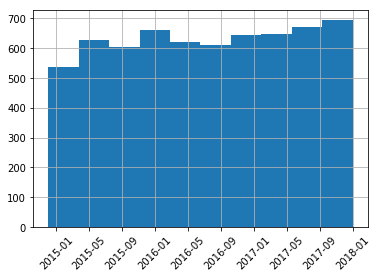

In [5]:
%matplotlib inline
print(data.loc[data['contract_start']<=pd.to_datetime('2014-12-01'), 'contract_id'].nunique())
subdata = data.loc[data['contract_start']>pd.to_datetime('2014-12-01'), ]
subdata.groupby('contract_id')['contract_start'].first().hist(xrot=45)

9015


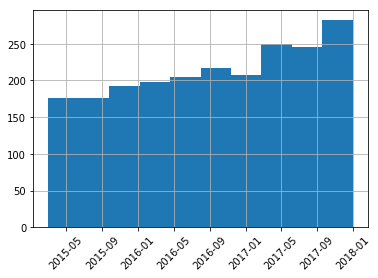

In [6]:
print(data.loc[data.contract_end == '2017-12-31 23:59:59','contract_id'].nunique())
subdata = data.loc[data.contract_end != '2017-12-31 23:59:59',:]
subdata.groupby('contract_id')['contract_end'].first().hist(xrot=45)

Bear in mind that a large number of contracts starts before 2014-12 and end after 2017-12 and are not graphed in the two graphs. We want to keep a decent length of data for bads evaluation and meantime want to keep most of IDs. It seems from the graphs that rtp at 2017-01-01 could be a good idea. It keeps 12 months to be examined for good or bad renters as well as keep many contracts alive before and after rtp.

In [7]:
# establish a reference time point
from datetime import datetime, timedelta
rtp = datetime(2017, 1, 1)

In [8]:
# split data into feature data and label data
def window_split_func(df, feature_window = timedelta(762), label_window = timedelta(365), rtp=rtp):
    feature_data = df[np.logical_and(df['Payment_date']<rtp, df['Payment_date']>rtp-feature_window)]
    label_data = df[np.logical_and(df['Payment_date']>=rtp, df['Payment_date']<=rtp+label_window)]
    return (feature_data, label_data)

In [9]:
feature_data, label_data = window_split_func(data)
print(feature_data['id'].nunique())
print(label_data['id'].nunique())

8274
9386


Check the number of cases that have to be dropped (if they only have transaction before rtp or after rtp)

In [10]:
inclusive_id = pd.merge(feature_data['id'], label_data['id']).drop_duplicates()
model_data = data[data['id'].isin(inclusive_id['id'])]
model_data['id'].nunique()

7709

In [11]:
# split data into feature data and label data
final_feature_data, final_label_data = window_split_func(model_data)

### 1.2 discretise continuous variables

There are multiple variables that are continuous and can be used to create features in the dataset, i.e. rent, transaction history, payment amount, overdue_days. As you can find later, this modelling practice intends to create three separate predictive model. One have more than one-year transaction history; one have over half-year but below one-year transaction history; one have less than half-year transaction history. In this sense, the transaction history is used to split the tenants into those three categories and is not used as feature. 

Additionally, the overdue_days is reflection of the ratio of payment amount over rent as I am going to show immediately afterwards. So in summary, I shall only discretise overdue days and rent.

In [12]:
data['payment_ratio'].value_counts()

1.00    220277
1.05     22721
1.10      9721
1.20      5769
1.50      1723
2.00       201
Name: payment_ratio, dtype: int64

In [13]:
overdue1 = data[data['payment_ratio'] == 1.05]
overdue2 = data[data['payment_ratio'] == 1.1]
overdue3 = data[data['payment_ratio'] == 1.2]
overdue4 = data[data['payment_ratio'] == 1.5]
print(overdue1['overdue_days'].min(), overdue1['overdue_days'].max())
print(overdue2['overdue_days'].min(), overdue2['overdue_days'].max())
print(overdue3['overdue_days'].min(), overdue3['overdue_days'].max())
print(overdue4['overdue_days'].min(), overdue4['overdue_days'].max())

3.0 7.0
8.0 14.0
15.0 30.0
31.0 61.0


Apparently there are four penalty ranges for overdue days:
1. between 3 and 7 days  (over three days to one week)
2. between 8 and 14 days (over week to two weeks)
2. between 15 and 30 days (over two week to one month)
3. between 31 and 61 days (over one month to two months)

Therefore as a primary concern, we can discretize the overdue days by following the same fashion. If so, we only need to use the 'payment_ratio' variable. However, because further analysis may require a adjustment of bins, I shall manually discretise overdue days.

In [15]:
# We bin the overdue days according to the payment_ratio
bins = [-.5, 2.5, 7.5, 14.5, 30.5, 61.5, 100]

overdue_bin = pd.cut(data.overdue_days, bins, labels=['minor', 'small', 'medium_small', 'medium_large', 'large', 'extreme_large'])
overdue_bin.name = 'overdue_bin'

In [16]:
rent_dist = data.groupby('id')['rent'].mean()

7970.0 400.0


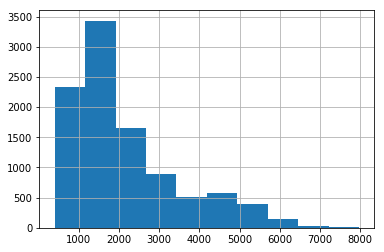

In [17]:
print(rent_dist.max(), rent_dist.min())
rent_dist.hist()

The rent ranges from 400 through nearly 8000 but mostly towards the lower end. In order to reflect such unequal distribution, I shall create smaller bins towards the lower end.

In [19]:
rent_bin = pd.cut(data.rent, bins=[0, 1000, 2000, 3000, 4000, 6000, 8000],
                 labels = ['minor','small', 'medium_small', 'medium_large', 'large', 'extreme_large'])
rent_bin.name = 'rent_bin'

In [20]:
data_bin = pd.concat([data, overdue_bin, rent_bin], axis=1)
data_bin.drop(['rent', 'Amount', 'payment_ratio', 'overdue_days'], axis=1, inplace=True)

In [21]:
model_data_bin = data_bin[data_bin['id'].isin(inclusive_id['id'])]

In [22]:
# split data into feature data and label data
final_feature_data_bin, final_label_data_bin = window_split_func(model_data_bin)

## 2. define bads and goods 

We can define bad renters accordingly but with subjective adjustment. The two general rule principals are:
1. the landlord needs to identify the extreme risky tenants. In the extreme cases, the tenants are to be evicted as I showed earlier. However, it is not economical to define the bad renters the same as the evicts. The reason is that it may take much more time to find another renter than one month or two. It means if tenants are evicited, the room may be left empty for a while and the landlord suffers a loss.

2. On the other hand, small delays in payments are not a big issue as long as it is not several small delays in a row as it may indicate that the renter may have a financial crisis. 

Based on these two principals, a bad renter is identified whenever any of the three conditions are met:


Given a time window, delay the payment
1. at least 3 days for any 3 consecutive months.
2. at least 8 days for any 2 consecutive months.
3. at least 15 days at least once. 

In [23]:
# define bad renters
def bads(df, small_delay = [3, 3], mid_delay = [2, 8], large_delay = 15):
    """ the small_delay and mid_delay are both list of two elements, the
        first element is the length of the consecutive window, the seond
        element is the minimum delays permitted."""
    months = df.shape[0]
    if sum(df['overdue_days']>=large_delay) >= 1:
        return 1
    for i in range(months):
        last1 = min(i + small_delay[0], months)
        if sum(df['overdue_days'].iloc[i:last1]>=small_delay[1]) == small_delay[0]:
            return 1
        last2 = min(i + mid_delay[0], months)
        if sum(df['overdue_days'].iloc[i:last2]>=mid_delay[1]) == mid_delay[0]:
            return 1
    return 0

In [24]:
bads_defined = final_label_data.groupby('id').apply(bads)

In [25]:
sum(bads_defined)/bads_defined.count()

0.21559216500194578

In [26]:
sum(bads_defined)

1662

In [27]:
bads_defined.count()

7709

**Note that I have a much stricter definition of bads than evict as argued above. Three minor delays, two medium small delays or one medium high delays all define a bad renter.** As a result, around 20\% renters are defined bad.

Before moving onto creating features, let me check whether evicted tenants are successfully into the bads. By defnition, they should have been defined as bads.

In [28]:
bads_idx = bads_defined[bads_defined == 1].index

evicted_idx = data.loc[data['evicted'] != 0, 'id'].drop_duplicates()

# Suspecious tenants who are evicted but not included in the bads.
exclusive_idx = evicted_idx[~evicted_idx.isin(bads_idx)]

# retrieve those suspecious tenants
suspect_data = data[data['id'].isin(exclusive_idx)]

# check the contract history of those suspecious tenants
suspect_data[np.logical_and(suspect_data['Payment_date']>rtp, suspect_data['contract_start']<rtp)]

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days,evicted


As we can see, There is no evicted tenants who has contract starting before 2017-01-01 and the payment date after 2017-01-01. To put it another way, all evicted tenants, as long as can be identified through such time window split, are included as bads.

## 3. create transactional features and preprocess data

### 3.1 create preliminary features for continuous dataset

I use seven types of features if continuous dataset is used.
1. single overdue_dates statistics, i.e. maximum of overdue days, mean of overdue days, standard deviations of overdue days and mode of overdue days.
2. adjacent overdue_dates statistics, i.e. maximum of the minimum of a consecutive overdue days, mean of the minimum, standard deviations of the minimum and mode of the minimum.
3. number of contracts
4. total transaction history before rtp (binnable)
5. number of payment methods
6. most frequently used payment methods
7. their rent level

In [29]:
def features_func(df, adj=1, adj_agg=pd.Series.min, 
                  stats_func={'max':pd.Series.max, 
                              'avg':pd.Series.mean}, 
                  sub_split=[datetime(2016, 7, 1),
                             datetime(2016, 1, 1)]):
    """
    adj is the maximum lengh of the consecutive months;
    adj_agg is the aggregate function to be performed on each consecutive series
    stats_func is the aggregate function to be performed on the series of of the aggregated value
    sub_split is the window splitting list That will split date according to the date specified.
    """

    var_dict = {}
    cum_months = 0
    window = [rtp] + sub_split + [datetime(2014, 12, 1)]
    for sub in range(1, len(window)):
        df_new = df[np.logical_and(df['Payment_date'] < window[sub-1], 
                                   df['Payment_date'] >= window[sub])]
        months = df_new.shape[0]
        cum_months += months

        if months == 0:
            var_dict['f_transact_len'] = cum_months
            return pd.DataFrame.from_dict(var_dict, orient='index')
            
        else:
            var_dict['fsub{}contract_num'.format(sub)] = df_new['contract_id'].nunique()
            var_dict['fsub{}pay_num'.format(sub)] = df_new['payment_method'].nunique()
            var_dict['fsub{}pay_mode'.format(sub)] = df_new['payment_method'].mode()[0]
            var_dict['fsub{}rent'.format(sub)] = df_new['rent'].mode()[0]
        
            for i in range(1, adj+1):
                adj_seq = []
                for j in range(months):
                    if i + j <= months:              
                        adj_seq.append(adj_agg(df_new.overdue_days[j:j+i]))
                for func_key, func_val in stats_func.items():
                    var_dict['fsub{}{}{}'.format(sub, func_key, i)] = func_val(pd.Series(adj_seq))
            if sub == 3:
                var_dict['f_transact_len'] = cum_months

                
    return pd.DataFrame.from_dict(var_dict, orient = 'index')

In [30]:
features = final_feature_data.groupby('id').apply(features_func, adj=3).unstack()
features.columns = features.columns.droplevel(0)

In [31]:
print(features.shape)
features.head()

(7709, 31)


,f_transact_len,fsub1avg1,fsub1avg2,fsub1avg3,fsub1contract_num,fsub1max1,fsub1max2,fsub1max3,fsub1pay_mode,fsub1pay_num,...,fsub3avg1,fsub3avg2,fsub3avg3,fsub3contract_num,fsub3max1,fsub3max2,fsub3max3,fsub3pay_mode,fsub3pay_num,fsub3rent
id,,,,,,,,,,,,,,,,,,,,,
Aadam Wright 1962-10-14,25,5.33333,3.6,3,1,13,6,6,DIRECT_DEBIT,1,...,2.38462,1.25,0.545455,1,13,9,3,DIRECT_DEBIT,1,870
Aadheen Davies 1983-01-06,25,0,0,0,1,0,0,0,DIRECT_DEBIT,1,...,0,0,0,1,0,0,0,DIRECT_DEBIT,1,4660
Aadya Adams 1973-09-20,25,0,0,0,1,0,0,0,DIRECT_DEBIT,1,...,0,0,0,1,0,0,0,DIRECT_DEBIT,1,1040
Aaliah Jones 1992-08-13,16,0.666667,0.2,0,2,2,1,0,DIRECT_DEBIT,1,...,0.5,0,0,1,2,0,0,DIRECT_DEBIT,1,1830
Aaliyah Leonard 1964-10-08,23,18.6,6.25,1.66667,1,51,20,5,DIRECT_DEBIT,1,...,8.75,3.81818,1,1,34,22,7,DIRECT_DEBIT,1,1520


In [33]:
def features_bin_func(df,
                  sub_split=[datetime(2016, 7, 1),
                             datetime(2016, 1, 1)]):
    """
    sub_split is the window splitting list That will split date according to the date specified
    """
    var_dict = {}
    cum_months = 0
    window = [rtp] + sub_split + [datetime(2014, 12, 1)]
    for sub in range(1, len(window)):
        df_new = df[np.logical_and(df['Payment_date'] < window[sub-1], 
                                   df['Payment_date'] >= window[sub])]
        
        overdue_bin = pd.get_dummies(df_new.overdue_bin)
        rent_bin = pd.get_dummies(df_new.rent_bin)

        if df_new.shape[0] == 0:
            return pd.DataFrame.from_dict(var_dict, orient='index')
            
        else:
            if df_new['contract_id'].nunique() == 1:
                var_dict['fsub{}contract'.format(sub)] = 'single'
            else:
                var_dict['fsub{}contract'.format(sub)] = 'multi'
            if df_new['payment_method'].nunique() == 1:
                var_dict['fsub{}pay_method'.format(sub)] = 'single'
            else:
                var_dict['fsub{}pay_method'.format(sub)] = 'multi'
            
            for i in range(overdue_bin.shape[1]):
                if i <= 3:
                    if sum(overdue_bin.iloc[:,i]) <= 0.33*len(overdue_bin.iloc[:,i]):
                        var_dict['fsub{}overdue_{}'.format(sub, overdue_bin.columns[i])] = 'low'
                    elif sum(overdue_bin.iloc[:,i]) <= 0.67*len(overdue_bin.iloc[:,i]):
                        var_dict['fsub{}overdue_{}'.format(sub, overdue_bin.columns[i])] = 'mid'
                    else:
                        var_dict['fsub{}overdue_{}'.format(sub, overdue_bin.columns[i])] = 'high'
                else:
                    if sum(overdue_bin.iloc[:,i]) >= 1:
                        var_dict['fsub{}overdue_{}'.format(sub, overdue_bin.columns[i])] = 'ocur'
                    else:
                        var_dict['fsub{}overdue_{}'.format(sub, overdue_bin.columns[i])] = 'non'
            
            var_dict['fsub{}rent'.format(sub)] = rent_bin.apply(sum).nlargest(1).index.values.astype('str')[0]

    return pd.DataFrame.from_dict(var_dict, orient = 'index')

In [34]:
features_bin = final_feature_data_bin.groupby('id').apply(features_bin_func).unstack()
features_bin.columns = features_bin.columns.droplevel(0)

In [35]:
print(features_bin.shape)
features_bin.head()

(7709, 27)


,fsub1contract,fsub1overdue_extreme_large,fsub1overdue_large,fsub1overdue_medium_large,fsub1overdue_medium_small,fsub1overdue_minor,fsub1overdue_small,fsub1pay_method,fsub1rent,fsub2contract,...,fsub2rent,fsub3contract,fsub3overdue_extreme_large,fsub3overdue_large,fsub3overdue_medium_large,fsub3overdue_medium_small,fsub3overdue_minor,fsub3overdue_small,fsub3pay_method,fsub3rent
id,,,,,,,,,,,,,,,,,,,,,
Aadam Wright 1962-10-14,single,non,non,low,low,mid,mid,single,minor,single,...,minor,single,non,non,low,low,high,low,single,minor
Aadheen Davies 1983-01-06,single,non,non,low,low,high,low,single,large,single,...,large,single,non,non,low,low,high,low,single,large
Aadya Adams 1973-09-20,single,non,non,low,low,high,low,single,small,single,...,small,single,non,non,low,low,high,low,single,small
Aaliah Jones 1992-08-13,multi,non,non,low,low,high,low,single,small,single,...,small,single,non,non,low,low,high,low,single,small
Aaliyah Leonard 1964-10-08,single,non,ocur,mid,low,low,low,single,small,single,...,small,single,non,ocur,low,low,mid,low,single,small


In [36]:
features_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7709 entries, Aadam Wright 1962-10-14 to Zuriel Page 1955-03-15
Data columns (total 27 columns):
fsub1contract                 7709 non-null object
fsub1overdue_extreme_large    7709 non-null object
fsub1overdue_large            7709 non-null object
fsub1overdue_medium_large     7709 non-null object
fsub1overdue_medium_small     7709 non-null object
fsub1overdue_minor            7709 non-null object
fsub1overdue_small            7709 non-null object
fsub1pay_method               7709 non-null object
fsub1rent                     7709 non-null object
fsub2contract                 6922 non-null object
fsub2overdue_extreme_large    6922 non-null object
fsub2overdue_large            6922 non-null object
fsub2overdue_medium_large     6922 non-null object
fsub2overdue_medium_small     6922 non-null object
fsub2overdue_minor            6922 non-null object
fsub2overdue_small            6922 non-null object
fsub2pay_method               6922 non-nul

### 3.2 split the feature datasets according to transaction history

In [37]:
cond_short = features.f_transact_len<=6
short_features = features[cond_short]
short_bin_features = features_bin[cond_short]

In [39]:
cond_medium = np.logical_and(features['f_transact_len']>6, features['f_transact_len']<=12)
medium_features = features[cond_medium]
medium_bin_features = features_bin[cond_medium]

In [40]:
cond_long = features['f_transact_len']>12
long_features = features[cond_long]
long_bin_features = features_bin[cond_long]

In [41]:
# fill in the NAs for fsub1avg2 and fusb1avg3 by fsub1avg1 in the same row. Same for max
short_features.loc[short_features['fsub1avg2'].isnull(), 'fsub1avg2'] = short_features.loc[short_features['fsub1avg2'].isnull(), 'fsub1avg1'].values
short_features.loc[short_features['fsub1avg3'].isnull(), 'fsub1avg3'] = short_features.loc[short_features['fsub1avg3'].isnull(), 'fsub1avg1'].values
short_features.loc[short_features['fsub1max2'].isnull(), 'fsub1max2'] = short_features.loc[short_features['fsub1max2'].isnull(), 'fsub1max1'].values
short_features.loc[short_features['fsub1max3'].isnull(), 'fsub1max3'] = short_features.loc[short_features['fsub1max3'].isnull(), 'fsub1max1'].values

short_features = short_features.loc[:, 'f_transact_len':'fsub1pay_num']
short_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 794 entries, Aamna Jenkins 1991-04-26 to Zuha Jones 1960-04-08
Data columns (total 10 columns):
f_transact_len       794 non-null object
fsub1avg1            794 non-null object
fsub1avg2            794 non-null object
fsub1avg3            794 non-null object
fsub1contract_num    794 non-null object
fsub1max1            794 non-null object
fsub1max2            794 non-null object
fsub1max3            794 non-null object
fsub1pay_mode        794 non-null object
fsub1pay_num         794 non-null object
dtypes: object(10)
memory usage: 108.2+ KB


There is no missing values for final_short_history_data now.

In [42]:
# fill in the NAs for fsub2avg2 and fusb2avg3 by fsub2avg1 in the same row. Same for max
medium_features.loc[medium_features['fsub2avg2'].isnull(), 'fsub2avg2'] = medium_features.loc[medium_features['fsub2avg2'].isnull(), 'fsub2avg1'].values
medium_features.loc[medium_features['fsub2avg3'].isnull(), 'fsub2avg3'] = medium_features.loc[medium_features['fsub2avg3'].isnull(), 'fsub2avg1'].values
medium_features.loc[medium_features['fsub2max2'].isnull(), 'fsub2max2'] = medium_features.loc[medium_features['fsub2max2'].isnull(), 'fsub2max1'].values
medium_features.loc[medium_features['fsub2max3'].isnull(), 'fsub2max3'] = medium_features.loc[medium_features['fsub2max3'].isnull(), 'fsub2max1'].values

medium_features = medium_features.loc[:, 'f_transact_len':'fsub2max']
medium_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 823 entries, Aaliyah Read 1978-02-28 to Zoya Williams 1966-06-25
Data columns (total 15 columns):
f_transact_len       823 non-null object
fsub1avg1            823 non-null object
fsub1avg2            823 non-null object
fsub1avg3            823 non-null object
fsub1contract_num    823 non-null object
fsub1max1            823 non-null object
fsub1max2            823 non-null object
fsub1max3            823 non-null object
fsub1pay_mode        823 non-null object
fsub1pay_num         823 non-null object
fsub1rent            823 non-null object
fsub2avg1            823 non-null object
fsub2avg2            823 non-null object
fsub2avg3            823 non-null object
fsub2contract_num    823 non-null object
dtypes: object(15)
memory usage: 142.9+ KB


There is no missing values for clean_medium_features now.

In [43]:
# fill in the NAs for fsub3avg2 and fusb2avg3 by fsub3avg1 in the same row.
long_features.loc[long_features['fsub3avg2'].isnull(), 'fsub3avg2'] = long_features.loc[long_features['fsub3avg2'].isnull(), 'fsub3avg1'].values
long_features.loc[long_features['fsub3avg3'].isnull(), 'fsub3avg3'] = long_features.loc[long_features['fsub3avg3'].isnull(), 'fsub3avg1'].values
long_features.loc[long_features['fsub3max2'].isnull(), 'fsub3max2'] = long_features.loc[long_features['fsub3max2'].isnull(), 'fsub3max1'].values
long_features.loc[long_features['fsub3max3'].isnull(), 'fsub3max3'] = long_features.loc[long_features['fsub3max3'].isnull(), 'fsub3max1'].values

long_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6092 entries, Aadam Wright 1962-10-14 to Zuriel Page 1955-03-15
Data columns (total 31 columns):
f_transact_len       6092 non-null object
fsub1avg1            6092 non-null object
fsub1avg2            6092 non-null object
fsub1avg3            6092 non-null object
fsub1contract_num    6092 non-null object
fsub1max1            6092 non-null object
fsub1max2            6092 non-null object
fsub1max3            6092 non-null object
fsub1pay_mode        6092 non-null object
fsub1pay_num         6092 non-null object
fsub1rent            6092 non-null object
fsub2avg1            6092 non-null object
fsub2avg2            6092 non-null object
fsub2avg3            6092 non-null object
fsub2contract_num    6092 non-null object
fsub2max1            6092 non-null object
fsub2max2            6092 non-null object
fsub2max3            6092 non-null object
fsub2pay_mode        6092 non-null object
fsub2pay_num         6092 non-null object
fsub2rent         

### 3.3 further data preprocessing

There are still a few variables that are categorical variables and we need to transform them into dummies. Additionally, most of data are in 'object' type and should have been changed into float type.

In [44]:
def float_tran_func(ser):
    if 'avg' in ser.name:
        ser = ser.astype('float')
    elif 'max' in ser.name:
        ser = ser.astype('float')
    elif not ser.name.endswith('pay_mode'):
        ser = ser.astype('uint8')
    return ser

In [106]:
final_short_features = short_features.apply(float_tran_func)
final_short_features = pd.get_dummies(final_short_features)
final_short_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 794 entries, Aamna Jenkins 1991-04-26 to Zuha Jones 1960-04-08
Data columns (total 12 columns):
f_transact_len                 794 non-null uint8
fsub1avg1                      794 non-null float64
fsub1avg2                      794 non-null float64
fsub1avg3                      794 non-null float64
fsub1contract_num              794 non-null uint8
fsub1max1                      794 non-null float64
fsub1max2                      794 non-null float64
fsub1max3                      794 non-null float64
fsub1pay_num                   794 non-null uint8
fsub1pay_mode_BANK_TRANSFER    794 non-null uint8
fsub1pay_mode_CASH             794 non-null uint8
fsub1pay_mode_DIRECT_DEBIT     794 non-null uint8
dtypes: float64(6), uint8(6)
memory usage: 88.1+ KB


In [46]:
final_medium_features = medium_features.apply(float_tran_func)
final_medium_features = pd.get_dummies(final_medium_features)
final_medium_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 823 entries, Aaliyah Read 1978-02-28 to Zoya Williams 1966-06-25
Data columns (total 17 columns):
f_transact_len                 823 non-null uint8
fsub1avg1                      823 non-null float64
fsub1avg2                      823 non-null float64
fsub1avg3                      823 non-null float64
fsub1contract_num              823 non-null uint8
fsub1max1                      823 non-null float64
fsub1max2                      823 non-null float64
fsub1max3                      823 non-null float64
fsub1pay_num                   823 non-null uint8
fsub1rent                      823 non-null uint8
fsub2avg1                      823 non-null float64
fsub2avg2                      823 non-null float64
fsub2avg3                      823 non-null float64
fsub2contract_num              823 non-null uint8
fsub1pay_mode_BANK_TRANSFER    823 non-null uint8
fsub1pay_mode_CASH             823 non-null uint8
fsub1pay_mode_DIRECT_DEBIT     823 non-

In [47]:
final_long_features = long_features.apply(float_tran_func)
final_long_features = pd.get_dummies(final_long_features)
final_long_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6092 entries, Aadam Wright 1962-10-14 to Zuriel Page 1955-03-15
Data columns (total 37 columns):
f_transact_len                 6092 non-null uint8
fsub1avg1                      6092 non-null float64
fsub1avg2                      6092 non-null float64
fsub1avg3                      6092 non-null float64
fsub1contract_num              6092 non-null uint8
fsub1max1                      6092 non-null float64
fsub1max2                      6092 non-null float64
fsub1max3                      6092 non-null float64
fsub1pay_num                   6092 non-null uint8
fsub1rent                      6092 non-null uint8
fsub2avg1                      6092 non-null float64
fsub2avg2                      6092 non-null float64
fsub2avg3                      6092 non-null float64
fsub2contract_num              6092 non-null uint8
fsub2max1                      6092 non-null float64
fsub2max2                      6092 non-null float64
fsub2max3           

In [48]:
final_short_bin_features = pd.get_dummies(short_bin_features.loc[:, 'fsub1contract':'fsub1rent'])
final_medium_bin_features = pd.get_dummies(medium_bin_features.loc[:, 'fsub1contract':'fsub2rent'])
final_long_bin_features = pd.get_dummies(long_bin_features)

In [49]:
bads_defined.name = 'target'
final_short_bads = bads_defined[bads_defined.index.isin(final_short_features.index)]
final_medium_bads = bads_defined[bads_defined.index.isin(final_medium_features.index)]
final_long_bads = bads_defined[bads_defined.index.isin(final_long_features.index)]

In [50]:
# combine feature data with label data
final_short_data = pd.concat([final_short_bads, final_short_features], axis=1)
final_medium_data = pd.concat([final_medium_bads, final_medium_features], axis=1)
final_long_data = pd.concat([final_long_bads, final_long_features], axis=1)

In [51]:
# combine bin_feature data with label data
final_short_bin_data = pd.concat([final_short_bads, final_short_bin_features], axis=1)
final_medium_bin_data = pd.concat([final_medium_bads, final_medium_bin_features], axis=1)
final_long_bin_data = pd.concat([final_long_bads, final_long_bin_features], axis=1)

## 4. predictive modelling

In [57]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix

def model_eval_func(df, test_ratio, 
                    cross_val_metrics=['precision',
                                      'recall',
                                      'roc_auc'], 
                    score_metrics={'precision':precision_score,
                                  'recall':recall_score,
                                  'roc_auc':roc_auc_score,
                                  'confusion_matrix': confusion_matrix},
                   feature_selection=True):
    
    from sklearn.model_selection import train_test_split
    from sklearn.feature_selection import SelectFromModel
    from sklearn.ensemble import ExtraTreesClassifier
    
    train_set, test_set = train_test_split(df, test_size = test_ratio, random_state=30)
    X_train = train_set.iloc[:, 1:]
    y_train = train_set.iloc[:, 0]
    X_test = test_set.iloc[:, 1:]
    y_test = test_set.iloc[:, 0]
    
    clf_etc = ExtraTreesClassifier(n_estimators=50)
    clf_etc = clf_etc.fit(X_train, y_train)
    features_rf_importance = clf_etc.feature_importances_
    model = SelectFromModel(clf_etc, prefit=True)
    features_idx = model.get_support()
    features_rf_name = X_train.columns[features_idx]
    X_train_new = model.transform(X_train)
    
    if feature_selection:
        clf = LogisticRegression().fit(X_train_new, y_train)
        y_fit = clf.predict(X_train_new)
        y_pred = clf.predict(X_test.iloc[:, features_idx])
    else:
        clf = LogisticRegression().fit(X_train, y_train)
        y_fit = clf.predict(X_train)
        y_pred = clf.predict(X_test)

    
    for score in cross_val_metrics:
        if feature_selection:
            print("train set cross val {} are".format(score), cross_val_score(clf, X_train_new, y_train, cv=3, scoring=score))
        else:
            print("train set cross val {} are".format(score), cross_val_score(clf, X_train, y_train, cv=3, scoring=score))
    for key, values in score_metrics.items():
        print("train set {} are ".format(key), values(y_fit, y_train))
    for key, values in score_metrics.items():
        print("test set {} are".format(key), values(y_pred, y_test))

    if feature_selection:
        print ('selected features used in modelling are', features_rf_name)
    else:
        ser = pd.Series(clf.coef_[0])
        ser.index = X_train.columns
        return clf.intercept_, ser

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [62]:
model_eval_func(final_short_data, .3)

train set cross val precision are [0.88       0.79310345 0.81481481]
train set cross val recall are [0.45833333 0.47916667 0.45833333]
train set cross val roc_auc are [0.86891727 0.83553832 0.85256995]
train set precision are  0.4652777777777778
train set recall are  0.8271604938271605
train set roc_auc are  0.8323566182215971
train set confusion_matrix are  [[397  77]
 [ 14  67]]
test set precision are 0.3111111111111111
test set recall are 0.5185185185185185
test set roc_auc are 0.6861460517120894
test set confusion_matrix are [[181  31]
 [ 13  14]]
selected features used in modelling are Index(['f_transact_len', 'fsub1avg1', 'fsub1avg2', 'fsub1max1', 'fsub1max2',
       'fsub1max3'],
      dtype='object')


In [63]:
model_eval_func(final_medium_data, .3)

train set cross val precision are [0.76923077 0.86666667 0.73076923]
train set cross val recall are [0.45454545 0.60465116 0.44186047]
train set cross val roc_auc are [0.85753508 0.90533791 0.8664362 ]
train set precision are  0.5076923076923077
train set recall are  0.7674418604651163
train set roc_auc are  0.8184148077835786
train set confusion_matrix are  [[426  64]
 [ 20  66]]
test set precision are 0.5961538461538461
test set recall are 0.7948717948717948
test set roc_auc are 0.8469551282051282
test set confusion_matrix are [[187  21]
 [  8  31]]
selected features used in modelling are Index(['fsub1avg1', 'fsub1avg2', 'fsub1avg3', 'fsub1max1', 'fsub1max2',
       'fsub1rent', 'fsub2avg1'],
      dtype='object')


In [64]:
model_eval_func(final_long_data, .3)

train set cross val precision are [0.83838384 0.80582524 0.79425837]
train set cross val recall are [0.55704698 0.55704698 0.55892256]
train set cross val roc_auc are [0.89551787 0.88671063 0.87466083]
train set precision are  0.5643896976483762
train set recall are  0.8262295081967214
train set roc_auc are  0.8598854163862643
train set confusion_matrix are  [[3265  389]
 [ 106  504]]
test set precision are 0.542713567839196
test set recall are 0.8212927756653993
test set roc_auc are 0.8524994229764695
test set confusion_matrix are [[1383  182]
 [  47  216]]
selected features used in modelling are Index(['f_transact_len', 'fsub1avg1', 'fsub1avg2', 'fsub1avg3', 'fsub1max1',
       'fsub1max2', 'fsub1max3', 'fsub1rent', 'fsub2avg1', 'fsub2avg2',
       'fsub2avg3', 'fsub2max1', 'fsub2max2', 'fsub2rent', 'fsub3avg1',
       'fsub3avg2', 'fsub3max1', 'fsub3max2', 'fsub3rent'],
      dtype='object')


When comparing among three models using continuous features, short-history model performs worse than medium-history model, which again performs worse than long-history model. This finding makes sense as the predictive information is very limited in the short-history model as most of features are based only on a very short time window (<= 6 months).

Another finding is that features created from different time window (0-6 months ago; 7 months ago- 12 months ago; 13 months ago to 25 months ago) have significant predictive power. Across all three models, fsub1 features are constantly selected in the final model (using the tree method for variable selection). fsub2 and fsub3 features are also selected in the long-history model.

In [65]:
short_bin_features_selected = model_eval_func(final_short_bin_data, .3)

train set cross val precision are [0.79310345 0.63636364 0.71052632]
train set cross val recall are [0.47916667 0.4375     0.5625    ]
train set cross val roc_auc are [0.71996655 0.71859793 0.74931569]
train set precision are  0.5208333333333334
train set recall are  0.7211538461538461
train set roc_auc are  0.7840802490192734
train set confusion_matrix are  [[382  69]
 [ 29  75]]
test set precision are 0.4444444444444444
test set recall are 0.6060606060606061
test set roc_auc are 0.7423506913798176
test set confusion_matrix are [[181  25]
 [ 13  20]]
selected features used in modelling are Index(['fsub1overdue_medium_small_low', 'fsub1overdue_medium_small_mid',
       'fsub1overdue_minor_high', 'fsub1overdue_minor_mid',
       'fsub1overdue_small_low', 'fsub1overdue_small_mid'],
      dtype='object')


In [66]:
medium_bin_features_selected = model_eval_func(final_medium_bin_data, .3)

train set cross val precision are [0.62962963 0.71111111 0.64583333]
train set cross val recall are [0.77272727 0.74418605 0.72093023]
train set cross val roc_auc are [0.82824893 0.88114562 0.87774984]
train set precision are  0.8
train set recall are  0.6753246753246753
train set roc_auc are  0.8068566504585462
train set confusion_matrix are  [[396  26]
 [ 50 104]]
test set precision are 0.8653846153846154
test set recall are 0.6818181818181818
test set roc_auc are 0.8215720743345052
test set confusion_matrix are [[174   7]
 [ 21  45]]
selected features used in modelling are Index(['fsub1overdue_medium_small_low', 'fsub1overdue_medium_small_mid',
       'fsub1overdue_minor_high', 'fsub1overdue_minor_low',
       'fsub1overdue_minor_mid', 'fsub1overdue_small_low',
       'fsub1overdue_small_mid', 'fsub1pay_method_multi',
       'fsub1pay_method_single', 'fsub2overdue_minor_high',
       'fsub2overdue_minor_mid'],
      dtype='object')


In [67]:
long_bin_features_selected = model_eval_func(final_long_bin_data, .3)

train set cross val precision are [0.76363636 0.75494071 0.69708029]
train set cross val recall are [0.70469799 0.6409396  0.64309764]
train set cross val roc_auc are [0.88453719 0.88337433 0.87102698]
train set precision are  0.6741321388577828
train set recall are  0.7261761158021713
train set roc_auc are  0.8207299792984656
train set confusion_matrix are  [[3144  291]
 [ 227  602]]
test set precision are 0.6557788944723618
test set recall are 0.725
test set roc_auc are 0.8158378746594006
test set confusion_matrix are [[1331  137]
 [  99  261]]
selected features used in modelling are Index(['fsub1overdue_large_non', 'fsub1overdue_medium_large_low',
       'fsub1overdue_medium_large_mid', 'fsub1overdue_medium_small_low',
       'fsub1overdue_medium_small_mid', 'fsub1overdue_minor_high',
       'fsub1overdue_minor_low', 'fsub1overdue_minor_mid',
       'fsub1overdue_small_low', 'fsub1overdue_small_mid',
       'fsub1pay_method_multi', 'fsub1pay_method_single',
       'fsub2overdue_medi

The three models using discretised features have similar predictive performance as those using continuous features. Again, the features selected from three different time window are selected in these three models.

In addition, amongh all six models, the number of contracts do not play a predictive role, the rent level only contribute to the predictive power in short-history model.

## 5. WOE scorecard

### 5.1 WOE calculation

Since the predictive performance between continuous features and discretised features do not differ from each other much. So this section intends to use the shrinked discretised features only to create a scorecard. Specifically, I shall run a simple logistic regression on the Weight of Evidence (WOE) of each feature rather than the features themselves. The benefits of using WOE is that they can capture the nonlinearities in the predictive relationship.

In [69]:
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["VALUE"] = df2.sum().Y.index
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_NON_EVENT/d3.DIST_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','VALUE', 'WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            conv = char_bin(target, df1[i])
            conv["VAR_NAME"] = i
#             conv['id'] = conv['VAR_NAME'] + '_' + conv['VALUE']
            count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df[['VAR_NAME', 'VALUE', 'WOE', 'IV']],iv)

In [70]:
short_bin_features = short_bin_features.loc[:, 'fsub1contract':'fsub1rent']
medium_bin_features = medium_bin_features.loc[:, 'fsub1contract':'fsub2rent']
long_bin_features = long_bin_features.loc[:, 'fsub1contract':'fsub3rent']

In [136]:
WOE_short_bin, IV = data_vars(short_bin_features, final_short_bads)

IV = IV.sort_values('IV', ascending=False).reset_index(drop=True)
short_idx = IV['VAR_NAME'][:4]
WOE_short_bin = WOE_short_bin.sort_values('IV', ascending=False).reset_index()
IV

,VAR_NAME,IV
0,fsub1overdue_minor,1.153015
1,fsub1overdue_small,0.460119
2,fsub1overdue_medium_small,0.239531
3,fsub1overdue_medium_large,0.180362
4,fsub1rent,0.091641
5,fsub1overdue_large,0.002323
6,fsub1pay_method,0.000709
7,fsub1contract,0.000022
8,fsub1overdue_extreme_large,0.000000


It supports the finding in the last section: contract and payment_method plays a minor role in the model. there is no overdue_extreme_large in the short-history data. 

In [125]:
pd.concat([short_bin_features, final_short_bads], axis=1).groupby('fsub1overdue_minor').apply(lambda x: x['target'].sum()/x['target'].count())

fsub1overdue_minor
high    0.143075
low     0.833333
mid     0.672269
dtype: float64

In [137]:
WOE_medium_bin, IV = data_vars(medium_bin_features, final_medium_bads)
IV = IV.sort_values('IV', ascending=False).reset_index(drop=True)
medium_idx = IV['VAR_NAME'][:9]
WOE_medium_bin = WOE_medium_bin.sort_values('IV', ascending=False).reset_index()
IV

,VAR_NAME,IV
0,fsub1overdue_minor,2.338800
1,fsub1overdue_small,0.931136
2,fsub2overdue_minor,0.755696
3,fsub1overdue_medium_small,0.522824
4,fsub1overdue_medium_large,0.505035
5,fsub1overdue_large,0.308733
6,fsub2overdue_medium_small,0.221459
7,fsub2overdue_medium_large,0.182755
8,fsub2overdue_small,0.163641
9,fsub1rent,0.059104


In [138]:
WOE_long_bin, IV = data_vars(long_bin_features, final_long_bads)
IV = IV.sort_values('IV', ascending=False).reset_index(drop=True)
long_idx = IV['VAR_NAME'][:16]
WOE_long_bin = WOE_long_bin.sort_values('IV', ascending=False).reset_index()
IV

,VAR_NAME,IV
0,fsub1overdue_minor,2.253075
1,fsub2overdue_minor,1.544621
2,fsub3overdue_minor,0.965062
3,fsub1overdue_small,0.875430
4,fsub1overdue_medium_small,0.581233
5,fsub2overdue_small,0.560279
6,fsub1overdue_medium_large,0.423288
7,fsub2overdue_medium_small,0.415555
8,fsub1overdue_large,0.383499
9,fsub3overdue_large,0.268014


In [139]:
def mapper_func(ser, WOE):
    df_new = WOE[WOE.VAR_NAME == ser.name]
    for iter_ in range(df_new.shape[0]):
        ser[ser == df_new.iloc[iter_]['VALUE']] = df_new.iloc[iter_]['WOE']
    return ser  

def WOE_transform_func(df, WOE, idx):
    df_new = df.loc[:, idx]
    WOE_new = WOE[WOE.VAR_NAME.isin(idx)]
    return df_new.apply(mapper_func, WOE = WOE)

In [74]:
# def mapper_func(ser, WOE):
#     df_new = WOE[WOE.VAR_NAME == ser.name]
#     for iter_ in range(df_new.shape[0]):
#         ser[ser == df_new.iloc[iter_]['VALUE']] = df_new.iloc[iter_]['WOE']
#     return ser  

# def WOE_transform_func(df, WOE):
#     idx = df.columns[df.columns.isin(WOE['VAR_NAME'])]
# #     df_new = df[df.columns.isin(WOE['VAR_NAME'])]
# #     WOE_new = WOE[WOE.VAR_NAME.isin(idx)]
#     df_new = df[idx]
#     return df_new.apply(mapper_func, WOE = WOE)

In [140]:
short_bin_WOE = WOE_transform_func(short_bin_features, WOE_short_bin, short_idx)
medium_bin_WOE = WOE_transform_func(medium_bin_features, WOE_medium_bin, medium_idx)
long_bin_WOE = WOE_transform_func(long_bin_features, WOE_long_bin, long_idx)

final_short_data = pd.concat([final_short_bads, short_bin_WOE], axis=1)
final_medium_data = pd.concat([final_medium_bads, medium_bin_WOE], axis=1)
final_long_data = pd.concat([final_long_bads, long_bin_WOE], axis=1)

### 5.2 scorecard construction

In [141]:
short_intercept, short_bin_coef = model_eval_func(final_short_data, 0.3, feature_selection=False)

train set cross val precision are [0.79310345 0.67567568 0.71052632]
train set cross val recall are [0.47916667 0.52083333 0.5625    ]
train set cross val roc_auc are [0.72087895 0.72893856 0.74946776]
train set precision are  0.5208333333333334
train set recall are  0.7211538461538461
train set roc_auc are  0.7840802490192734
train set confusion_matrix are  [[382  69]
 [ 29  75]]
test set precision are 0.4444444444444444
test set recall are 0.6060606060606061
test set roc_auc are 0.7423506913798176
test set confusion_matrix are [[181  25]
 [ 13  20]]


In [142]:
medium_intercept, medium_bin_coef = model_eval_func(final_medium_data, 0.3, feature_selection=False)

train set cross val precision are [0.62264151 0.73170732 0.63829787]
train set cross val recall are [0.75       0.69767442 0.69767442]
train set cross val roc_auc are [0.828554   0.8338536  0.85237272]
train set precision are  0.7692307692307693
train set recall are  0.6666666666666666
train set roc_auc are  0.7981220657276995
train set confusion_matrix are  [[396  30]
 [ 50 100]]
test set precision are 0.8269230769230769
test set recall are 0.671875
test set roc_auc are 0.8113473360655736
test set confusion_matrix are [[174   9]
 [ 21  43]]


In [143]:
long_intercept, long_bin_coef = model_eval_func(final_long_data, 0.3, feature_selection=False)

train set cross val precision are [0.78823529 0.76305221 0.74793388]
train set cross val recall are [0.67449664 0.63758389 0.60942761]
train set cross val roc_auc are [0.88859449 0.88468945 0.88052535]
train set precision are  0.6461366181410975
train set recall are  0.7713903743315508
train set roc_auc are  0.8407577582693021
train set confusion_matrix are  [[3200  316]
 [ 171  577]]
test set precision are 0.6130653266331658
test set recall are 0.7697160883280757
test set roc_auc are 0.8338984147795243
test set confusion_matrix are [[1357  154]
 [  73  244]]


The following formula illustrate the process of scaling scorecards

$$\text{score} = \text{offset} + \text{Factor}\cdot\ln(\text{odds})$$

$\ln(\text{odds}) = -\Sigma\beta_{i}\cdot WOE_j + \alpha$, 

where $\beta_{i}$ is the sequence of model coefficients, $WOE_j$ is the discretised variable and $\alpha$ is the intercept

$\text{Factor} = pdo/\ln(2)$

$\text{offset} = Score - [\text{Factor}\cdot \ln(\text{odds}))]$

For example, if a scorecard were being scaled where the user wanted odds of 50:1 at 600 points and wanted the odds to double every 20 points, the factor and offset would be:

$\text{Factor} = 20/\ln(2) = 28.8539$

$\text{offset} = 600 - 28.8539\cdot \ln(50) = 487.123$

Lastly, the score formula for each characterisitc is 

$$-(\beta_i\cdot\text{WOE}_j + \frac{\alpha}{n})\cdot\text{Factor} + \frac{\text{offset}}{n}$$,

where n is the number of WOEs.

In [144]:
def match_func(df_woe, df_coef):
    df_woe_new = df_woe[df_woe.VAR_NAME.isin(df_coef.index)].reset_index()
    beta = []
    for int_iter in range(df_woe_new.shape[0]):
        beta.extend(df_coef[df_coef.index == df_woe_new.iloc[int_iter]['VAR_NAME']].values)
    beta = pd.Series(beta)
    beta.name = 'beta'
    out = pd.concat([df_woe_new[['VAR_NAME', 'VALUE', 'WOE']], beta], axis = 1)
    out.set_index('VAR_NAME', inplace=True)
    return out

# def score_formula_func(woe, )

def scorecard_func(df_woe, alpha, pdo_double=20, score=600, odds=50):
    from scipy import log
    factor = pdo_double/log(2)
    offset = score - factor*log(odds)
    df_woe['score'] = -(df_woe.beta*df_woe.WOE + alpha/df_woe.shape[0])*factor + offset/df_woe.shape[0] 
    return df_woe[['VALUE', 'score']]
    
    

In [145]:
# temp = match_func(WOE_short_bin, short_bin_coef)
scorecard_short = scorecard_func(match_func(WOE_short_bin, short_bin_coef), short_intercept)
scorecard_short

,VALUE,score
VAR_NAME,,
fsub1overdue_minor,mid,-8.637844
fsub1overdue_minor,high,71.688618
fsub1overdue_minor,low,-37.168892
fsub1overdue_small,high,51.626506
fsub1overdue_small,low,48.584278
fsub1overdue_small,mid,70.666791
fsub1overdue_medium_small,low,53.089992
fsub1overdue_medium_small,mid,14.181523
fsub1overdue_medium_large,low,52.801246


In [147]:
# temp = match_func(WOE_medium_bin, medium_bin_coef)
scorecard_medium = scorecard_func(match_func(WOE_medium_bin, medium_bin_coef), medium_intercept)
scorecard_medium

,VALUE,score
VAR_NAME,,
fsub1overdue_minor,low,-41.075745
fsub1overdue_minor,high,55.646808
fsub1overdue_minor,mid,-21.916867
fsub1overdue_small,mid,19.323684
fsub1overdue_small,low,21.317947
fsub1overdue_small,high,19.193227
fsub2overdue_minor,mid,13.932293
fsub2overdue_minor,low,4.978827
fsub2overdue_minor,high,23.212764


In [148]:
# temp = match_func(WOE_long_bin, long_bin_coef)
scorecard_long = scorecard_func(match_func(WOE_long_bin, long_bin_coef), long_intercept)
scorecard_long

,VALUE,score
VAR_NAME,,
fsub1overdue_minor,high,38.986412
fsub1overdue_minor,mid,-21.877018
fsub1overdue_minor,low,-52.148608
fsub2overdue_minor,high,25.610117
fsub2overdue_minor,low,-20.754570
fsub2overdue_minor,mid,-7.526765
fsub3overdue_minor,mid,2.883763
fsub3overdue_minor,high,16.407299
fsub3overdue_minor,low,-3.110635


In [105]:
print(final_long_data.groupby('fsub1pay_method').apply(lambda x: x['target'].sum()/x['target'].count()))
print(final_long_data.groupby('fsub1overdue_minor').apply(lambda x: x['target'].sum()/x['target'].count()))
final_long_data = pd.concat([final_long_bads, long_bin_features], axis=1)
print(final_long_data.groupby('fsub2pay_method').apply(lambda x: x['target'].sum()/x['target'].count()))
print(final_long_data.groupby('fsub2overdue_minor').apply(lambda x: x['target'].sum()/x['target'].count()))
print(final_long_data.groupby('fsub3overdue_minor').apply(lambda x: x['target'].sum()/x['target'].count()))

fsub1pay_method
-5.245233    0.980769
 0.040097    0.205298
dtype: float64
fsub1overdue_minor
-3.111101    0.857868
-1.654334    0.584416
 1.274613    0.069913
dtype: float64
fsub2pay_method
multi     0.921569
single    0.205926
dtype: float64
fsub2overdue_minor
high    0.092489
low     0.759067
mid     0.542065
dtype: float64
fsub3overdue_minor
high    0.128637
low     0.746939
mid     0.540509
dtype: float64


It seems that people who has multiple payment method history are those with really high bad rates. And counter-intuitively, those people with no delay have much worse bad rates than with 

In [79]:
# # long_bin_features = long_bin_features.drop(['fsub1pay_method', 'fsub2pay_method'], axis=1)
# long_bin_WOE = WOE_transform_func(long_bin_features, WOE_long_bin, long_idx)
# WOE_long_bin, IV = data_vars(long_bin_features, final_long_bads)
# IV = IV.sort_values('IV', ascending=False).reindex()
# long_idx = IV['VAR_NAME'][:14]

In [80]:
# long_intercept, long_bin_coef = model_eval_func(pd.concat([final_long_bads, long_bin_WOE], axis=1), 0.4, feature_selection=False)
# temp = match_func(WOE_long_bin, long_bin_coef)
# scorecard_long = scorecard_func(temp, long_intercept)
# scorecard_long

In [81]:
# def features_payment_func(df):
#     var_dict = {}
#     var_dict['payment_num'] = df['payment_method']
#     var_dict['payment_main'] = df['payment_method'].mode()
#     return pd.DataFrame.from_dict(var_dict, orient='index')

In [82]:
# features_payment = final_feature_data.groupby('id').apply(features_payment_func)

In [83]:
# features_payment.head(5)